In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor
from sktime.regression.deep_learning.lstmfcn import LSTMFCNRegressor
import sktime
from collections import Counter
from IPython.display import display
pl.Config.set_tbl_rows(20)      # Increase max rows (default is 10)
pl.Config.set_tbl_cols(20)        # Increase max columns (default is 10)

df = pl.read_parquet("data/gold_df.parquet")
#TODO: feature scaling
scaling_cols = ['Systolic blood pressure', 'Age', 'pH measurement, arterial', 'Temperature', 'Hematocrit determination', 'Blood urea nitrogen measurement', 'Glucose measurement', 'Sodium measurement']
df = df.with_columns([
    (
        ((pl.col(c).cast(pl.Float64) - pl.col(c).cast(pl.Float64).min()) /
         (pl.col(c).cast(pl.Float64).max() - pl.col(c).cast(pl.Float64).min()))
        .alias(c)
    )
    for c in scaling_cols
])
df = df.with_columns([
    pl.col("Nursing Home").map_elements(lambda x: 0 if x==False else 1, return_dtype=pl.Int64).alias("Nursing Home"),
    pl.col("Gender").map_elements(lambda x: 0 if x == "M" else 1, return_dtype=pl.Int64).alias("Gender")  # M/F to 0/1
])

In [2]:
#train-test-split

test_subject_ids = [10037975, 10004733, 10009049]
df_test = df.filter(pl.col("subject_id").is_in(test_subject_ids)).drop(["subject_id", "CURB-65","hadm_id", "window_id"])
df_train = df.filter(~pl.col("subject_id").is_in(test_subject_ids)).drop(["subject_id", "CURB-65","hadm_id", "window_id"])

In [3]:
def get_sliding_windows(window_length, data, n):
    columns = data.columns
    #columns.remove('PSI/PORT')
    columns.remove('stay_id')
    window_dict = {column: [] for column in columns}
    agg_labels = []

    windows = pd.DataFrame()
    for i in (range(0, len(data) - window_length - 24)):
        window_data = data[i:(i + window_length)]
        window_label = data['PSI/PORT'][i+window_length+24]
        agg_labels.append(window_label)
        #window_data = window_data.drop('PSI/PORT')
        window_data = window_data.drop('stay_id')
        window_data = window_data.to_pandas()
        window_data.index.names = ['timepoints']
        window_data = window_data.set_index([pd.Index([n] * len(window_data), name='instance')], append=True)
        n += 1
        window_data = window_data.reorder_levels(['instance'] + list(window_data.index.names[:-1]))
        if windows.empty:
            windows = window_data
        else:
            windows = pd.concat([windows, window_data])
    agg_labels = pd.Series(agg_labels)
    #windows = pd.DataFrame.from_dict(window_dict)
    return windows, agg_labels, n


def get_windowed_data(wl, f):
    X = pd.DataFrame()
    y = None
    fs = f.partition_by("stay_id")
    n = 0
    for i in range(len(fs)):
        tmp = get_sliding_windows(wl, fs[i], n)
        n = tmp[2]
        if X.empty:
            X = tmp[0]
            y = tmp[1] 
        else: 
            X = pd.concat([X, tmp[0]])
            y = pd.concat([y, tmp[1]])
    return X, y
    
#TODO: separate sliding windows per patient 
X_test, y_test = get_windowed_data(5, df_test)
X_train, y_train = get_windowed_data(5, df_train)

def naive_drift(df):
    data = df["PSI/PORT"].tolist()
    series = []
    for i in range(0,len(data),5):
        start = data[i]
        end = data[i+4]
        exp = (end-start)*6
        series.append(exp)
    return pd.Series(series)
        

/tmp/ipykernel_6770/3172753946.py:42: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, tmp[1]])


In [4]:
pred_nd = naive_drift(X_test)
mse = mean_squared_error(y_test, pred_nd)
mae = mean_absolute_error(y_test, pred_nd)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 1069.331983805668
Mean Absolute Error: 28.967611336032387


In [5]:
regressor = KNeighborsTimeSeriesRegressor()
sktime.datatypes.check_raise(X_train, "pd-multiindex")
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 296.3562753036437
Mean Absolute Error: 11.133603238866396


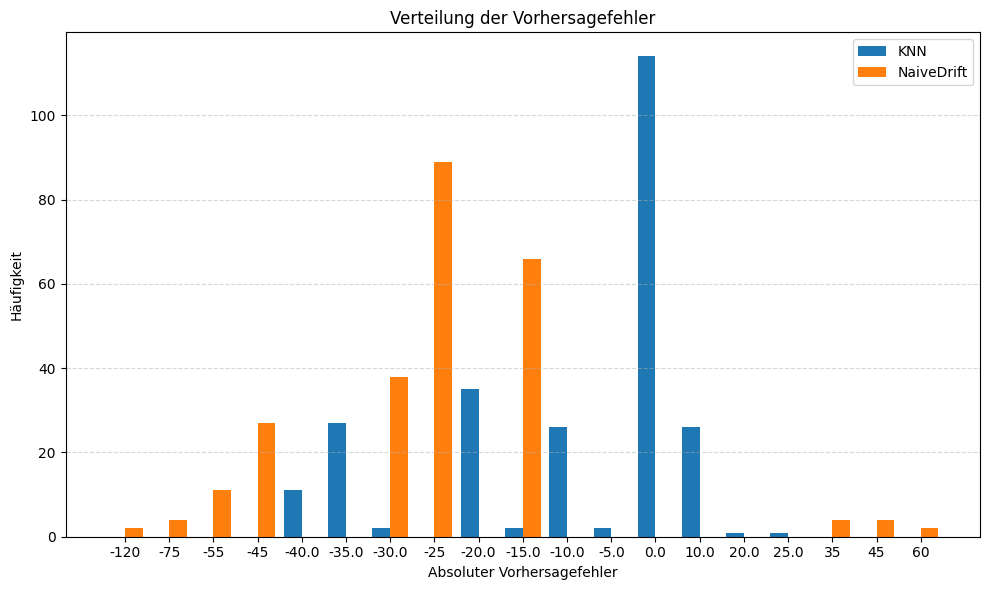

In [6]:
def eval(y_gold, y_pred, y_base):
    # Ensure numpy arrays
    y_gold = np.array(y_gold)
    y_pred = np.array(y_pred)
    y_base = np.array(y_base)

    # Compute signed errors
    err_knn = y_pred - y_gold
    err_naive = y_base - y_gold

    count_knn = Counter(err_knn)
    count_naive = Counter(err_naive)

    all_errors = sorted(set(count_knn.keys()).union(count_naive.keys()))

    knn_counts = [count_knn.get(e, 0) for e in all_errors]
    naive_counts = [count_naive.get(e, 0) for e in all_errors]

    x = np.arange(len(all_errors))
    width = 0.4

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, knn_counts, width, label='KNN')
    plt.bar(x + width/2, naive_counts, width, label='NaiveDrift')

    plt.xticks(x, all_errors)
    plt.xlabel('Absoluter Vorhersagefehler')
    plt.ylabel('Häufigkeit')
    plt.title('Verteilung der Vorhersagefehler')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("err_distr.png")
eval(y_test, y_pred, pred_nd)